# A First Look to the Train Dataset

The **goal of the competition** is to predict -- from a given snapshot in the game -- for each team, the probability that they will score within the next 10 seconds of game time.

The objective for this notebooks is to explore the data and get some first ideas of what we are dealing with. I'll be implementing and confirming some ideas posted in Kaggle's discussion forums and other resources.

I want to find an answer for the following topics:

1. If the objective of the competition is to predict the probability that either team A or B will score within the next 10 seconds of game time, I want to understand what data is available to us to make this prediction.
2. I want to understand the data behind the problem to later take a decision on how to approach the problem.
3. Finally, I want to understand how can I build features to capture the dynamics of the game and specially those factores that influece the probability of scoring.

## 0. Libraries and Personal Tools

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import sys
from os.path import abspath

import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from random import randint

In [2]:
# Set the default figure size and theme to display good looking matplotlib plots.
rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')

# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

# Check if the path is already added to sys.path
[p for p in sys.path if p.endswith("2022")]

# Import custom modules
from src.visualization.visualize import *

## 1. Get Raw Data

You can ignore the following cell if you are not interested in the details of how I got the data.

In [3]:
# # ===== GET DATA USING KAGGLE API =====
# kaggle config set -n competition -v tabular-playground-series-oct-2022
# kaggle config set -n path -v ~/Documents/my-kaggle-tools/competitions/tabular-playground-series-oct-2022/data/raw
# kaggle competitions download -c tabular-playground-series-oct-2022
# unzip ./data/raw/competitions/tabular-playground-series-oct-2022/tabular-playground-series-oct-2022.zip -d ./data/raw/
# rm -rf ./data/raw/competitions/

# # ===== CREATE NEW CSV WITH A SINGLE MATCH =====
# !head -n +1521 ./data/raw/train_0.csv > ./data/interim/single_match.csv

# # ===== CREATE A SAMPLE FOR LATER TESTING =====
# # Thanks to [Bar](https://stackoverflow.com/users/209882/bar). https://stackoverflow.com/a/37754402
# # and [nikkou](https://stackoverflow.com/users/1565833/nikkou)
# !tail -n +2 ./data/raw/train_0.csv | shuf -n 10000 > ./data/interim/sample.csv
# !head -1 ./data/raw/train_0.csv > ./data/interim/header.csv
# !cat ./data/interim/header.csv ./data/interim/sample.csv > ./data/interim/train_sample_10k.csv
# !rm ./data/interim/header.csv ./data/interim/sample.csv


From October TPS competition, we have the following datasets:

![files](./images/file_descriptions.png)

Notice the test set is scrambled, and since the goal of the competition is to **predict the probability of scoring within the next 10 seconds from a given snapshot in the game**, there is no relation between frames in the test set.

## 2. Load Sample Data

Since competition provides a file with dtypes in `train_dtype.csv`, we can use it to load the data in a more efficient way.  

Let's check the data type we need to handle.

In [4]:
dtypes_df = pd.read_csv("../data/raw/train_dtypes.csv")

According to the October TPS competetiton:

> The dataset consists of sequences of snapshots of the state of a Rocket League match, including position and velocity of all players and the ball, as well as extra information.

Also, 

> The data was taken from professional Rocket League matches. Each event consists of a chronological series of frames recorded at 10 frames per second.

In [5]:
dtypes = {k: v for (k, v) in zip(dtypes_df.column, dtypes_df.dtype)}
single_match_df = pd.read_csv("../data/interim/single_match.csv", dtype=dtypes)

![columns](./images/column_descriptions.png)

In [6]:
single_match_df.columns

Index(['game_num', 'event_id', 'event_time', 'ball_pos_x', 'ball_pos_y',
       'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 'p0_pos_x',
       'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost',
       'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
       'p1_boost', 'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y',
       'p2_vel_z', 'p2_boost', 'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x',
       'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p4_pos_x', 'p4_pos_y', 'p4_pos_z',
       'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p5_pos_x', 'p5_pos_y',
       'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost',
       'boost0_timer', 'boost1_timer', 'boost2_timer', 'boost3_timer',
       'boost4_timer', 'boost5_timer', 'player_scoring_next',
       'team_scoring_next', 'team_A_scoring_within_10sec',
       'team_B_scoring_within_10sec'],
      dtype='object')

Numbers sometimes have a better meaning if you can visualize them. Let's plot some of the data to get a better understanding of what we are dealing with.

Thanks to Sergey Saharovskiy who posted a great [notebook](https://www.kaggle.com/code/sergiosaharovskiy/tps-oct-2022-viz-players-positions-animated/notebook) with some visualizations. In this section, I'll be most of Sergey's code to have a better sense of what information is available to us and how can we use it to solve the challenge proposed by Kaggle.

## 3. Understanding the Data and the Challenge

Let's move backwards with this problem and analyze how can we use the information given by this problem to make our predictions.

If the input passed to the model to produce a prediction will be a snapshot of the game, we need to calculate:

1. `P[team A scoring within the next 10 seconds | X, theta]` 
2. `P[team B scoring within the next 10 seconds | X, theta]`

where,
- `X` is the information available in the match snapshot) will be a snapshot from the game
- `theta` the parameters of the model

As Ravi Shah already [discussed](https://www.kaggle.com/competitions/tabular-playground-series-oct-2022/discussion/356718) in Kaggle's forums, we can see three main feature categories in the data:

![features](./images/feature_overview.png)

### 3.1 Visualize Player and Ball positions

Let's visualize the positions of the players and the ball in a single Rocket League match (`game_num = 1`) to realize what kind of features we can engineer from this data and how important these features can be when we are trying to predict the probability of scoring within the next 10 seconds.

The following code produces a 2d plot of the positions of the players and the ball in the game for an specific event and a specific frame.

Again, thanks to Sergey Saharovskiy for the code! Kudos!

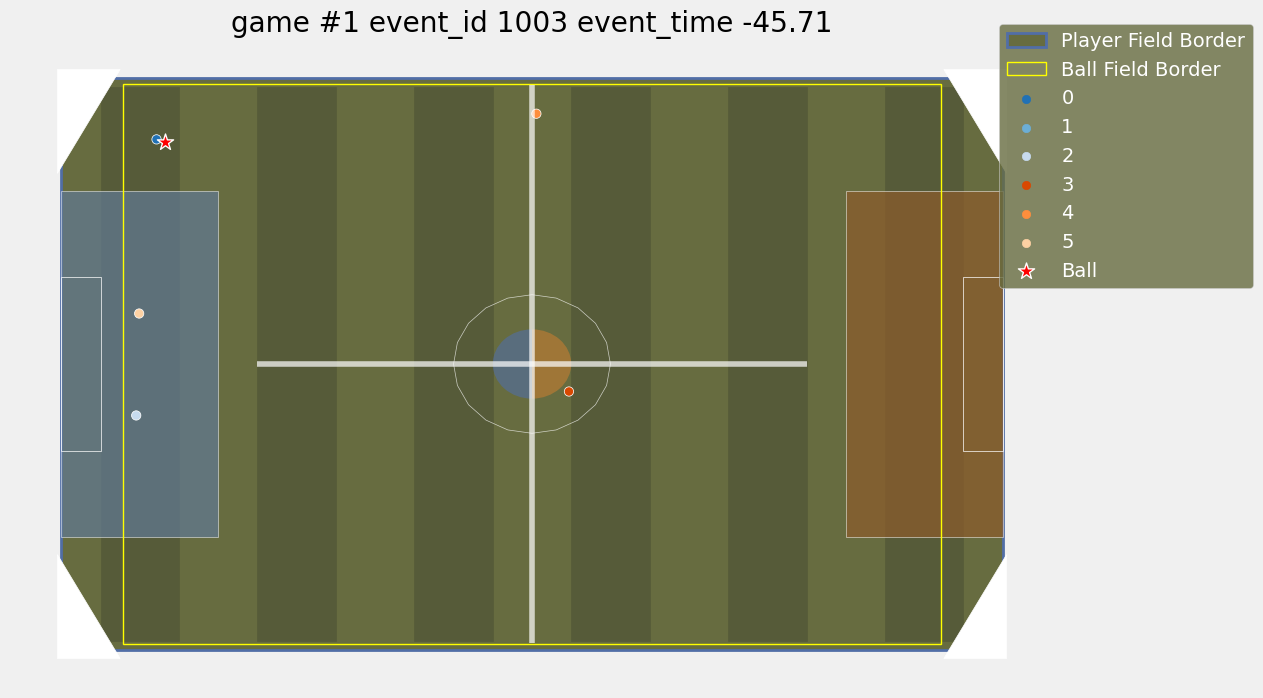

In [7]:
sample_i = randint(0, len(single_match_df)-1)

meta = {
    "game_num": single_match_df.loc[sample_i, "game_num"],
    "event_id": single_match_df.loc[sample_i, "event_id"],
    "event_time": single_match_df.loc[sample_i, "event_time"],
}

fig, ax = plt.subplots(1, figsize=(12, 8))
draw_rocket_league_position(single_match_df, meta, (fig, ax));

The visualization displayed above represents the positions of the players and the ball in game #1 for an specific event (game #1 contains two events `1002` and `1003`) and a specific frame.  

Along with more information about the players (such as their boost level, boost timer, and if they are currently demolished or not) and the ball (velocity) your model has to predict the probability of scoring within the next 10 seconds.

Ok, now that we have a better understanding of what we are dealing with, let's move to the next section and see if we can find some patterns in the data.

### 3.2 What happened before scoring?

If the challenge is to predict the probability of scoring within the next 10 seconds, we need to understand what happens before a goal is scored.
For the game #1, we have two events (`1002` and `1003`) where team B scored in both events. 

In [8]:
(
    single_match_df
    .groupby(["event_id", "team_scoring_next"])
    .player_scoring_next.nunique()
    )

event_id  team_scoring_next
1002      B                    1
1003      B                    1
Name: player_scoring_next, dtype: int64

If we group by `event_id` and `team_scoring_next` and count the number of frames, we can see that the number of frames in the fist event is `302`, and the number of frames in the second event is `1218`.

According to Kaggle TPS competition:

> Each event consists of a chronological series of frames recorded at 10 frames per second

That means, the first event took `302/10 = 30.2` seconds to finish, and the second event took `1218/10 = 121.8` seconds.

In [9]:
(
    single_match_df
    .groupby(["event_id", "team_scoring_next"])
    [["event_time"]]
    .agg(["min", "max", "count"])
    )

event_time                
                                   min       max count
event_id team_scoring_next                            
1002     B                  -33.313030 -0.036918   302
1003     B                 -135.037476 -0.035438  1218

Now, let's split both events (`1002` and `1003`) into two parts: the 10 seconds before a score and the rest of the event.

In [10]:
(
    single_match_df
    .groupby(["event_id", "team_B_scoring_within_10sec"])
    [["event_time"]]
    .agg(["min", "max", "count"])
    )

event_time                 
                                             min        max count
event_id team_B_scoring_within_10sec                             
1002     0                            -33.313030 -10.011449   212
         1                             -9.902580  -0.036918    90
1003     0                           -135.037476 -10.034419  1127
         1                             -9.925831  -0.035438    91

Let's visualize a random position for event `1002` in both scenarios (10 seconds before a score and the rest of the match).

In [11]:
single_event_df = single_match_df[(single_match_df["game_num"] == 1) & (single_match_df["event_id"] == 1002)].reset_index().copy()
position_10s_before_score = randint(212, len(single_event_df)-1)
position_rest_of_the_match = randint(0, 211)

#### Snapshot of the game 10 seconds before a score

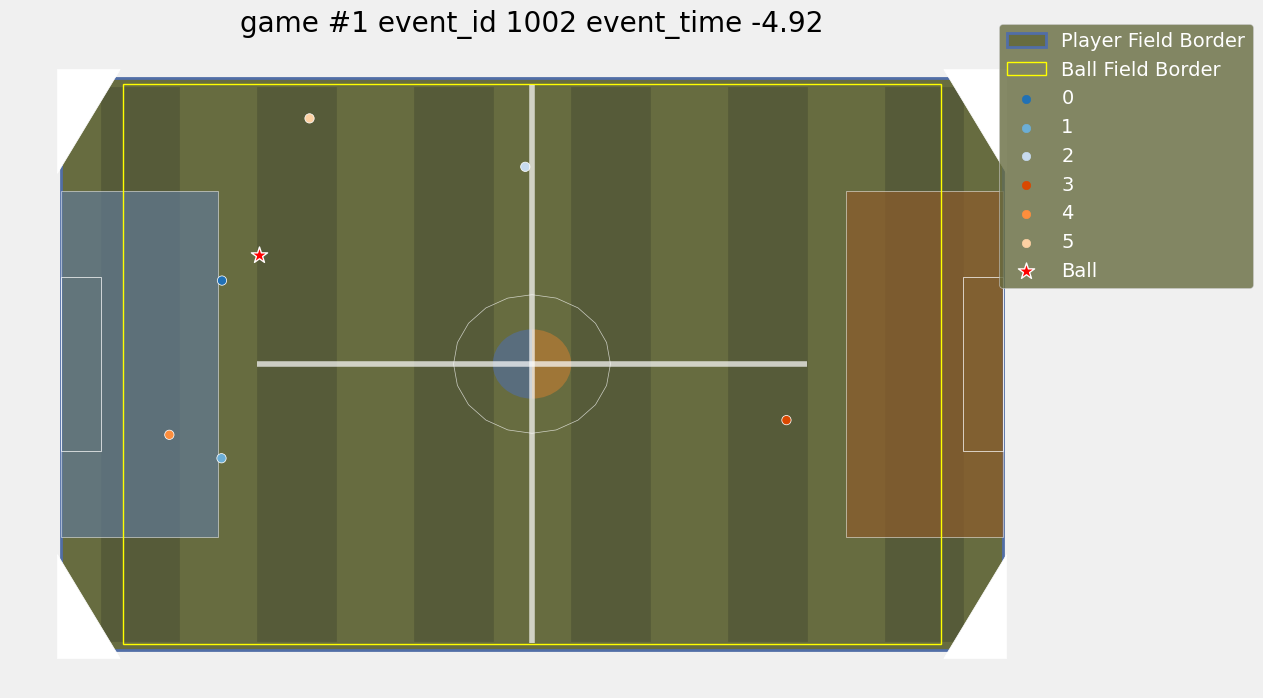

In [12]:
meta = {
    "game_num": 1,
    "event_id": 1002,
    "event_time": single_event_df.loc[position_10s_before_score, "event_time"],
}

fig, ax = plt.subplots(1, figsize=(12, 8))
draw_rocket_league_position(single_match_df, meta, (fig, ax));

In [13]:
single_match_df.loc[position_10s_before_score, :]

game_num                               1
event_id                            1002
event_time                     -4.918563
ball_pos_x                     31.408798
ball_pos_y                      -69.6828
                                 ...    
boost5_timer                         0.0
player_scoring_next                    3
team_scoring_next                      B
team_A_scoring_within_10sec            0
team_B_scoring_within_10sec            1
Name: 257, Length: 61, dtype: object

#### Snapshot of the game out of the range of 10 seconds before a score

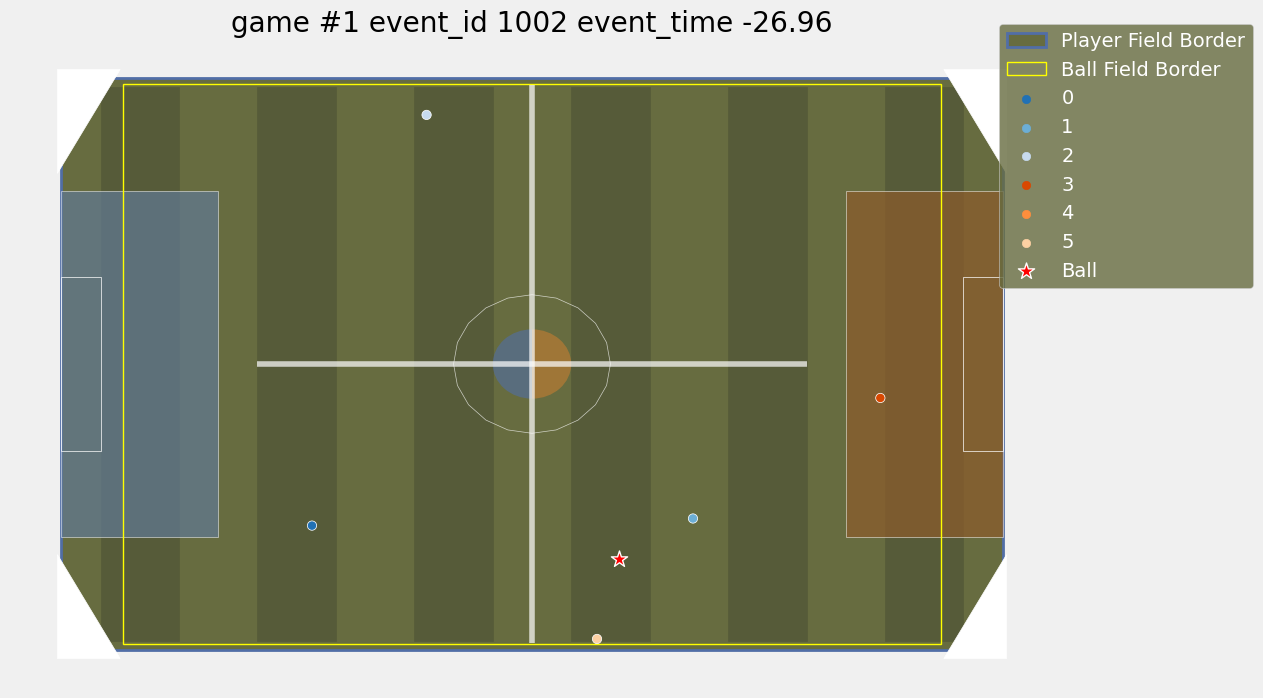

In [14]:
meta = {
    "game_num": 1,
    "event_id": 1002,
    "event_time": single_event_df.loc[position_rest_of_the_match, "event_time"],
}

fig, ax = plt.subplots(1, figsize=(12, 8))
draw_rocket_league_position(single_match_df, meta, (fig, ax));

In [15]:
single_match_df.loc[position_rest_of_the_match, :]

game_num                               1
event_id                            1002
event_time                    -26.960146
ball_pos_x                    -56.222599
ball_pos_y                       22.2948
                                 ...    
boost5_timer                         0.0
player_scoring_next                    3
team_scoring_next                      B
team_A_scoring_within_10sec            0
team_B_scoring_within_10sec            0
Name: 58, Length: 61, dtype: object

Did you noticed any differece between the two plots?

- I noticed that the ball is closer to the goal in the first plot.
- I also noticed that the players are closer to the ball in the first plot.
- In scond plot, there is a defender in the goal area from team B
- Ball is in the center of the field in the second plot.

All these observations come only from the position of the players and the ball, and only from a single snapshot of the game.

We also have additional information about the players and the ball, and all kind of features we can engineer from this data.

## 4. Conclusions

In this notebook, we explored the data and got some first ideas of what we were dealing with. We also implemented and confirmed some ideas posted in Kaggle's discussion forums and other resources.

We found an answer for the following topics:

> If the objective of the competition is to predict the probability that either team A or B will score within the next 10 seconds of game time, I want to understand what data is available to us to make this prediction.

- For each game recorded, we have a sequence of snapshots of the state of the game. Each game might have several events that either finished with team `A` or `B` scoring (as in the case of game #1), or some might end with no team scoring and truncated.
- For each event (who might end with a goal or not), we have a sequence of snapshots of the state of the game. We can divide each event into the 10 seconds before a score and the rest of the match.
- For each snapshot, we have the positions of the players and the ball, as well as extra information such as the boost level, boost timer, and if they are currently demolished or not.

> I want to understand the data behind the problem to decide later how to approach the problem.

- We can see three main feature categories in the data: player positions, ball positions, and extra information about the players (booster) and the ball (velocity).
- Most importantly, we can engineer many features from player positions relative to teammates, the ball, or the courtyard. 
- We can decide if reducing the training set into some "average" features grouped by ten-seconds-before-scoring and the rest of the match. Or, using the sequential information to add knowledge to our model (but remember, the input the model will receive is a SINGLE snapshot of the game, so that no additional information will help your model).

> Finally, I want to understand how can I build features to capture the dynamics of the game and specially those factores that influece the probability of scoring.

I have played a match or two in Rocket League, so I came up with ideas to build exciting features that might improve the first model I will develop.

Knowing that data was taken from professional Rocket League matches, I can say these pro players think very differently from the average casual players (like me), and they have spent countless hours learning various "tricks" to increase their probability of scoring.

Iĺl be building features around:

- Booster levels and everything related to power shots are critical when you want to score against the rival team.
- Jumping, flip resets, and overall air game are also very tricky to handle against pro players.
- Team coordination is vital for good performance at the highest levels of gameplay.
- Many pro players emphasize how important it is to pressure your opponents and never grant them ball control.
- Positioning, rotation, speed, and momentum.